# Mini Project 1

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
import datetime as dict

In [3]:
#download
tickers = ['NVDA', 'AMZN', 'TSLA', 'META', 'GOOG',  # Generally more volatile tech stocks
           'JNJ', 'KO', 'PG', 'HD', 'MCD']          # More stable, defensive companies

data = yf.download(tickers, period = "5y", interval = "1d", progress = False)

#preview the data
data.head()

YF.download() has changed argument auto_adjust default to True


Price            Close                                                \
Ticker            AMZN       GOOG          HD         JNJ         KO   
Date                                                                   
2020-06-25  137.729004  71.640663  217.548401  121.186333  38.607792   
2020-06-26  134.643494  67.593216  213.673996  119.572464  37.439152   
2020-06-29  134.018997  69.336342  218.204422  120.639679  38.117996   
2020-06-30  137.940994  70.262840  222.096481  122.019287  38.392963   
2020-07-01  143.934998  71.477127  220.004181  121.802391  38.513260   

Price                                                                ...  \
Ticker             MCD        META      NVDA          PG       TSLA  ...   
Date                                                                 ...   
2020-06-25  163.021591  234.394104  9.458823  104.230797  65.732002  ...   
2020-06-26  160.327774  214.901047  9.124925  101.879013  63.982666  ...   
2020-06-29  163.057297  219.436157  9.169775  104.027458  67.290001  ...   
2020-06-30  164.546936  225.831085  9.466547  105.716164  71.987335  ...   
2020-07-01  164.716446  236.253891  9.498690  106.078674  74.641998  ...   

Price          Volume                                                  \
Ticker           AMZN      GOOG       HD       JNJ        KO      MCD   
Date                                                                    
2020-06-25   59374000  24610000  2938400   7421200  13829700  3145200   
2020-06-26  130016000  85354000  5002700  12849700  21955100  5107400   
2020-06-29   84468000  36204000  3468300   5309800  17603900  2622200   
2020-06-30   75394000  40848000  4524600   7738300  23679800  3163100   
2020-07-01  127268000  35504000  3677300   6174800  14316500  2193800   

Price                                                 
Ticker          META       NVDA        PG       TSLA  
Date                                                  
2020-06-25  18704300  376072000   5489300  138817500  
2020-06-26  76343900  592084000  23201700  132823500  
2020-06-29  58514300  342248000   6866900  135396000  
2020-06-30  33927100  367892000   7818000  253777500  
2020-07-01  43399700  326648000   6501200  199903500  

[5 rows x 50 columns]

In [4]:
close = data["Close"]
normalized_returns = close/close.iloc[0]-1 #moves sotck prices to a start of 0

#create multiindex columns for new data

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])
data = pd.concat([data, normalized_returns], axis = 1)

#Calculate log daily returns
log_returns = np.log(close / close.shift(1))
log_returns = log_returns.dropna()

#add to main df
log_returns.columns = pd.MultiIndex.from_product([['Log Returns'], log_returns.columns])
data = pd.concat([data, log_returns], axis = 1)

#step 3: annualized volatility (std x sqrt(252))
annualized_vol = {ticker: np.std(log_returns['Log Returns', ticker]) * np.sqrt(252)
                                for ticker in tickers}

#display volatility
vol_df = pd.DataFrame.from_dict(annualized_vol, orient = 'index', columns=['Annualized Volatility'])
vol_df = vol_df.sort_values(by = 'Annualized Volatility', ascending = False)
display(vol_df)

,Annualized Volatility
TSLA,0.641165
NVDA,0.525335
META,0.445031
AMZN,0.356785
GOOG,0.310924
HD,0.236266
MCD,0.173193
PG,0.172192
KO,0.167367
JNJ,0.167142


In [5]:
#riskiest stocks
high_risk = vol_df.head(5).index.tolist()

#safest stocks
low_risk = vol_df.tail(5).index.tolist()

print("High-Risk Portfolio:", high_risk)
print("Low-Risk Portfolio:", low_risk)

High-Risk Portfolio: ['TSLA', 'NVDA', 'META', 'AMZN', 'GOOG']
Low-Risk Portfolio: ['HD', 'MCD', 'PG', 'KO', 'JNJ']


In [6]:
#Calculate Portfolio Returns (Equal Weighting)

#1. Equal weights
n_high = len(high_risk)
n_low = len(low_risk)

high_weights = np.array([1/n_high] * n_high)
low_weights = np.array([1/n_low] * n_low)

#2. Daily returns subset
high_risk_returns = log_returns['Log Returns'][high_risk]
low_risk_returns = log_returns['Log Returns'][low_risk]

#3. Portfolio daily returns
high_portfolio_returns = high_risk_returns.dot(high_weights)
low_portfolio_returns = low_risk_returns.dot(low_weights)

#4. Cumulative Returns
high_cumulative = (1 + high_portfolio_returns).cumprod() - 1
low_cumulative = (1 + low_portfolio_returns).cumprod() - 1

In [7]:
#Assuming 252 trading days in a year
trading_days = 252
risk_free_rate = 0

#high risk portfolio stats
high_mean_daily = high_portfolio_returns.mean()
high_vol_daily = high_portfolio_returns.std()

high_annual_return = (1 + high_mean_daily) ** trading_days -1
high_annual_vol = high_vol_daily * np.sqrt(trading_days)
high_sharpe = (high_annual_return - risk_free_rate) / high_annual_vol

#low risk portfolio stats
low_mean_daily = low_portfolio_returns.mean()
low_vol_daily = low_portfolio_returns.std()

low_annual_return = (1 + low_mean_daily) ** trading_days -1
low_annual_vol = low_vol_daily * np.sqrt(trading_days)
low_sharpe = (low_annual_return - risk_free_rate) / low_annual_vol

#display comparison

summary = pd.DataFrame({
    'Annual Return': [high_annual_return, low_annual_return],
    'Annual Volatility': [high_annual_vol, low_annual_vol],
    'Sharpe Ratio': [high_sharpe, low_sharpe]
}, index = ['High-Risk Portfolio', 'Low-Risk Portfolio'])

display(summary)

,Annual Return,Annual Volatility,Sharpe Ratio
High-Risk Portfolio,0.313398,0.354604,0.883797
Low-Risk Portfolio,0.098001,0.133549,0.733824


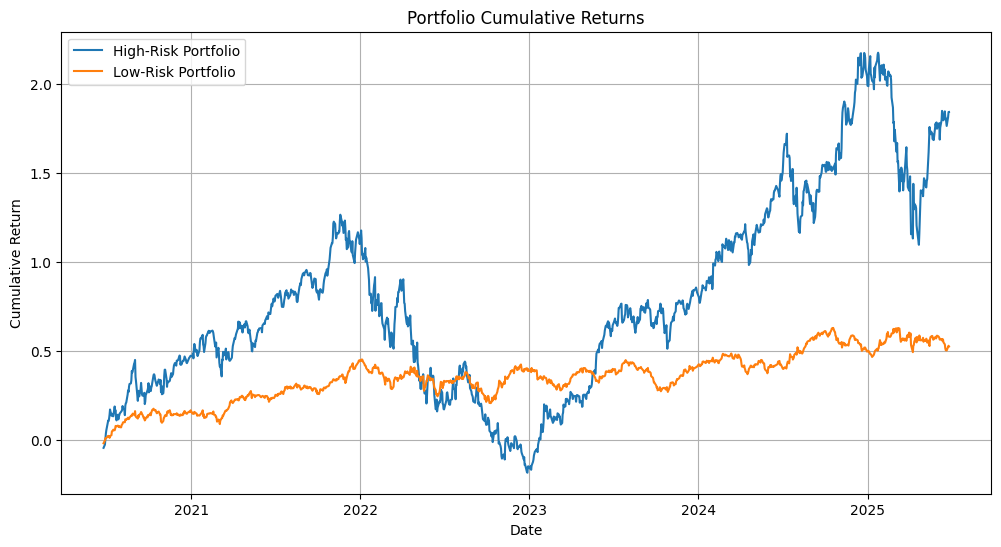

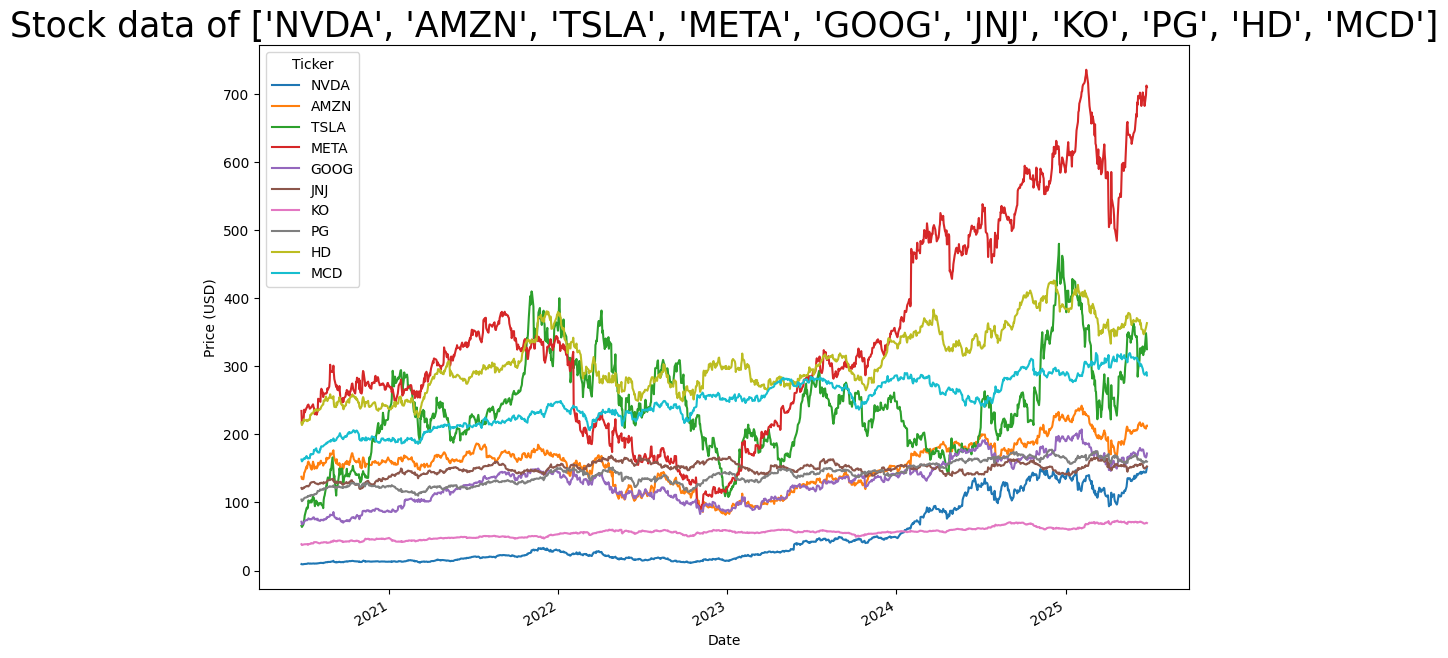

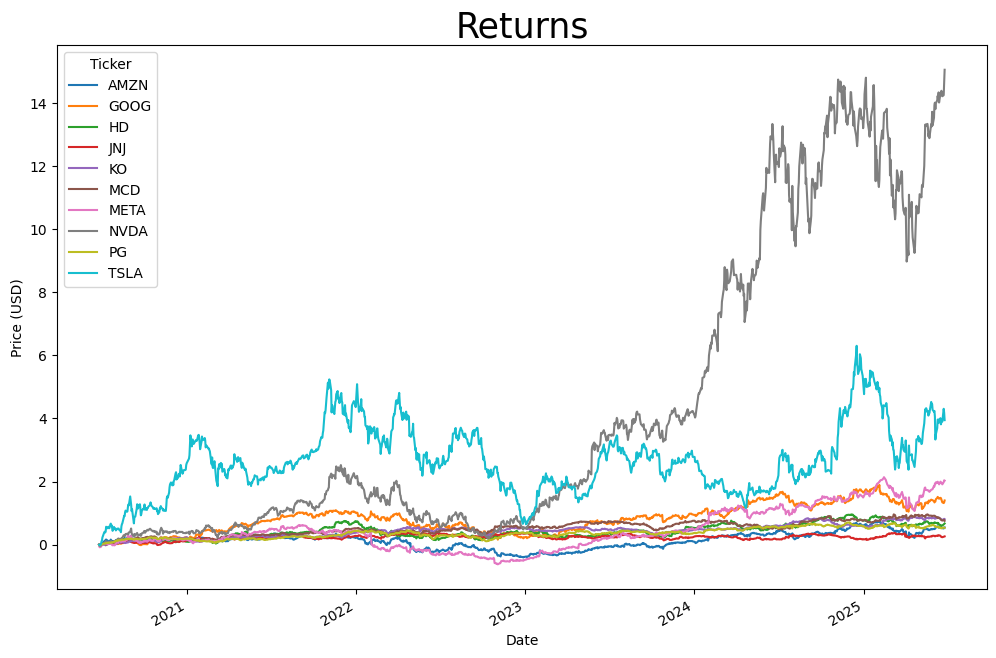

In [8]:
plt.figure(figsize=(12,6))
plt.plot(high_cumulative, label="High-Risk Portfolio")
plt.plot(low_cumulative, label="Low-Risk Portfolio")
plt.title("Portfolio Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


data["Close"][tickers].plot(figsize=(12,8))
plt.title(f'Stock data of {tickers}', size = 25)
plt.ylabel("Price (USD)")

data['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()